In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as m

import imblearn.over_sampling

import xgboost as xgb

import warnings

In [2]:
# turn off JN warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('clean_india_credit_data.csv')
dummy_df = pd.read_csv('clean_india_credit_data_dummy.csv')

In [4]:
# naive default rate

df.default.sum()/len(df)

0.123

In [5]:
# separate target and features

dummy_df_Y = dummy_df['default']
dummy_df_X = dummy_df.loc[:,'income':]

In [6]:
# train test split three datasets

X_train, X_test, Y_train, Y_test = train_test_split(dummy_df_X, dummy_df_Y, test_size=.2,random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.25,random_state=42)


In [7]:
# confirm split sizes, class distribution in splits

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(np.mean(Y_train))
print(np.mean(Y_val))
print(np.mean(Y_test))

(151200, 86)
(50400, 86)
(50400, 86)
0.1226058201058201
0.12311507936507937
0.12406746031746031


In [8]:
# resampling param

n_pos = np.sum(Y_train == 1)
n_neg = np.sum(Y_train == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 


# randomly oversample positive samples: create 4x as many 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_train_res, Y_train_res = ROS.fit_resample(X_train, Y_train)


# set params for f-beta

beta = 2


In [9]:
def roc_plot(fpr,tpr,model_name='model'):
    """
    Plot ROC-AUC curve for given FPs and TPs of a model
    """
    
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='black',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve ({model_name})',fontweight='bold')

KNN classification metrics with no resampling
___________________________________________________________________________________________
KNN classification accuracy of:  0.8882539682539683
KNN classification recall of:  0.41418211120064463
KNN classification precision of:  0.5627326472520254
KNN classification F1 of:  0.47716301522465654
KNN classification F-beta (2) of:  0.4372681798073978
-----------------------------------------------------------

ROC AUC score =  0.8735908556312999


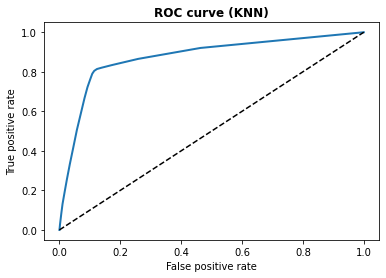

In [10]:
######################################
### knn with no over/undersampling ###
######################################


# fit the model 

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train,Y_train)

prob_preds_knn = knn.predict_proba(X_val)[:,1]
Y_pred_knn = knn.predict(X_val)


# ROC curve

fpr_knn, tpr_knn, thresholds_knn = m.roc_curve(Y_val, prob_preds_knn)
roc_plot(fpr=fpr_knn,tpr=tpr_knn,model_name='KNN')

knn_acc = m.accuracy_score(Y_val, Y_pred_knn)
knn_recall = m.recall_score(Y_val, Y_pred_knn)
knn_prec = m.precision_score(Y_val, Y_pred_knn)
knn_f1 = m.f1_score(Y_val, Y_pred_knn)
knn_fbeta = m.fbeta_score(Y_val, Y_pred_knn, beta)
knn_roc = m.roc_auc_score(Y_val, prob_preds_knn)

knn_stats = [knn_acc, knn_recall, knn_prec, knn_f1, knn_fbeta, knn_roc]


# diagnostic

print('\033[1m''KNN classification metrics with no resampling''\033[0m')
print('\033[1m''___________________________________________________________________________________________''\033[0m')
print('KNN classification accuracy of: ',knn_acc)
print('KNN classification recall of: ',knn_recall)
print('KNN classification precision of: ',knn_prec)
print('KNN classification F1 of: ',knn_f1)
print(f'KNN classification F-beta ({beta}) of: ',knn_fbeta)

print('-----------------------------------------------------------')
print('')
print("ROC AUC score = ", knn_roc)

KNN classification metrics with resampling
___________________________________________________________________________________________
KNN classification accuracy of:  0.8774603174603175
KNN classification recall of:  0.8128928283642224
KNN classification precision of:  0.5014414951784472
KNN classification F1 of:  0.6202656173143137
KNN classification F-beta (2) of:  0.7230711889675736
-----------------------------------------------------------

ROC AUC score =  0.8800150931713429


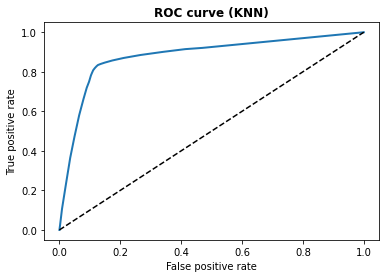

In [11]:
###################################
### knn with over/undersampling ###
###################################


# fit the model 

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_res,Y_train_res)

prob_preds_knn = knn.predict_proba(X_val)[:,1]
Y_pred_knn = knn.predict(X_val)


# ROC curve

fpr_knn, tpr_knn, thresholds_knn = m.roc_curve(Y_val, prob_preds_knn)
roc_plot(fpr=fpr_knn,tpr=tpr_knn,model_name='KNN')

knn_acc_res = m.accuracy_score(Y_val, Y_pred_knn)
knn_recall_res = m.recall_score(Y_val, Y_pred_knn)
knn_prec_res = m.precision_score(Y_val, Y_pred_knn)
knn_f1_res = m.f1_score(Y_val, Y_pred_knn)
knn_fbeta_res = m.fbeta_score(Y_val, Y_pred_knn, beta)
knn_roc_res = m.roc_auc_score(Y_val, prob_preds_knn)

knn_stats_res = [knn_acc_res, knn_recall_res, knn_prec_res, knn_f1_res, knn_fbeta_res, knn_roc_res]


# diagnostic

print('\033[1m''KNN classification metrics with resampling''\033[0m')
print('\033[1m''___________________________________________________________________________________________''\033[0m')
print('KNN classification accuracy of: ',knn_acc_res)
print('KNN classification recall of: ',knn_recall_res)
print('KNN classification precision of: ',knn_prec_res)
print('KNN classification F1 of: ',knn_f1_res)
print(f'KNN classification F-beta ({beta}) of: ',knn_fbeta_res)

print('-----------------------------------------------------------')
print('')
print("ROC AUC score = ", knn_roc_res)

Logistic Regression classification metrics with no resampling
___________________________________________________________________________________________

Logistic regression (hard preds) accuracy of:  0.8768849206349206
Logistic regression (hard preds) recall of:  0.0
Logistic regression (hard preds) precision of:  0.0
Logistic regression (hard preds) F1 of:  0.0
Logistic regression (hard preds) F-beta (2) of:  0.0
-----------------------------------------------------------

Logistic regression (soft preds with 0.17 decision threshold) accuracy of:  0.8340674603174603
Logistic regression (soft preds with 0.17 decision threshold) recall of:  0.11845286059629331
Logistic regression (soft preds with 0.17 decision threshold) precision of:  0.2025909592061742
Logistic regression (soft preds with 0.17 decision threshold) F1 of:  0.149496593104851
Logistic regression (soft preds with 0.17 decision threshold) F-beta (2) of:  0.12918307086614175
Logistic regression (soft preds with 0.17 decisi

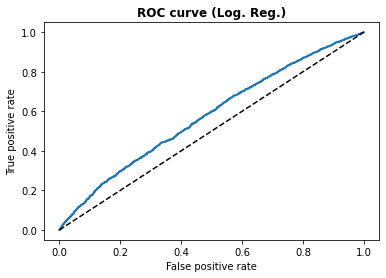

In [12]:
######################################################
### logistic regression with no over/undersampling ###
######################################################


# fit the model 

lr = LogisticRegression(C=1)
lr.fit(X_train, Y_train)

dec_threshold = .17
prob_preds_lr = lr.predict_proba(X_val)[:,1]
dec_prob_preds_lr = lr.predict_proba(X_val)[:,1] > dec_threshold
Y_pred_lr = lr.predict(X_val)


# ROC curve

fpr_lr, tpr_lr, thresholds_lr = m.roc_curve(Y_val, prob_preds_lr)
roc_plot(fpr=fpr_lr,tpr=tpr_lr,model_name='Log. Reg.')

lr_acc = m.accuracy_score(Y_val, Y_pred_lr)
lr_recall = m.recall_score(Y_val, Y_pred_lr)
lr_prec = m.precision_score(Y_val, Y_pred_lr)
lr_f1 = m.f1_score(Y_val, Y_pred_lr)
lr_fbeta = m.fbeta_score(Y_val, Y_pred_lr, beta)
lr_roc = m.roc_auc_score(Y_val, prob_preds_lr)

lr_stats = [lr_acc, lr_recall, lr_prec, lr_f1, lr_fbeta, lr_roc]

# diagnostic

print('\033[1m''Logistic Regression classification metrics with no resampling''\033[0m')
print('\033[1m''___________________________________________________________________________________________''\033[0m')
print('')
print('Logistic regression (hard preds) accuracy of: ', lr_acc)
print('Logistic regression (hard preds) recall of: ', lr_recall)
print('Logistic regression (hard preds) precision of: ', lr_prec)
print('Logistic regression (hard preds) F1 of: ', lr_f1)
print(f'Logistic regression (hard preds) F-beta ({beta}) of: ', lr_fbeta)

print('-----------------------------------------------------------')
print('')
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) accuracy of: ',m.accuracy_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) recall of: ',m.recall_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) precision of: ',m.precision_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) F1 of: ',m.f1_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) F-beta ({beta}) of: ',m.fbeta_score(Y_val, dec_prob_preds_lr, beta))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) log loss of: ',m.log_loss(Y_val, prob_preds_lr))

print('-----------------------------------------------------------')
print('')
print("ROC AUC score = ", lr_roc)

Logistic Regression classification metrics with resampling
___________________________________________________________________________________________

Logistic regression (hard preds) accuracy of:  0.8704563492063492
Logistic regression (hard preds) recall of:  0.032393231265108784
Logistic regression (hard preds) precision of:  0.2768595041322314
Logistic regression (hard preds) F1 of:  0.05800028855864955
Logistic regression (hard preds) F-beta (2) of:  0.0393407969936585
-----------------------------------------------------------

Logistic regression (soft preds with 0.17 decision threshold) accuracy of:  0.1252579365079365
Logistic regression (soft preds with 0.17 decision threshold) recall of:  0.9988718775181306
Logistic regression (soft preds with 0.17 decision threshold) precision of:  0.12327459326146625
Logistic regression (soft preds with 0.17 decision threshold) F1 of:  0.21946426358373317
Logistic regression (soft preds with 0.17 decision threshold) F-beta (2) of:  0.4126

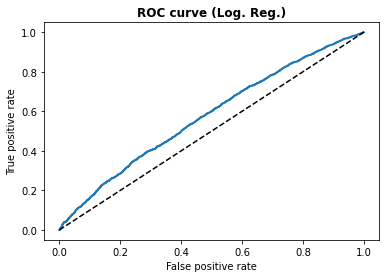

In [13]:
###################################################
### logistic regression with over/undersampling ###
###################################################


# fit the model 

lr = LogisticRegression(C=1)
lr.fit(X_train_res, Y_train_res)

dec_threshold = .17
prob_preds_lr = lr.predict_proba(X_val)[:,1]
dec_prob_preds_lr = lr.predict_proba(X_val)[:,1] > dec_threshold
Y_pred_lr = lr.predict(X_val)


# ROC curve

fpr_lr, tpr_lr, thresholds_lr = m.roc_curve(Y_val, prob_preds_lr)
roc_plot(fpr=fpr_lr,tpr=tpr_lr,model_name='Log. Reg.')

lr_acc_res = m.accuracy_score(Y_val, Y_pred_lr)
lr_recall_res = m.recall_score(Y_val, Y_pred_lr)
lr_prec_res = m.precision_score(Y_val, Y_pred_lr)
lr_f1_res = m.f1_score(Y_val, Y_pred_lr)
lr_fbeta_res = m.fbeta_score(Y_val, Y_pred_lr,beta)
lr_roc_res = m.roc_auc_score(Y_val, prob_preds_lr)

lr_stats_res = [lr_acc_res, lr_recall_res, lr_prec_res, lr_f1_res, lr_fbeta_res, lr_roc_res]


# diagnostic

print('\033[1m''Logistic Regression classification metrics with resampling''\033[0m')
print('\033[1m''___________________________________________________________________________________________''\033[0m')
print('')
print('Logistic regression (hard preds) accuracy of: ', lr_acc_res)
print('Logistic regression (hard preds) recall of: ', lr_recall_res)
print('Logistic regression (hard preds) precision of: ', lr_prec_res)
print('Logistic regression (hard preds) F1 of: ', lr_f1_res)
print(f'Logistic regression (hard preds) F-beta ({beta}) of: ', lr_fbeta_res)


print('-----------------------------------------------------------')
print('')
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) accuracy of: ',m.accuracy_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) recall of: ',m.recall_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) precision of: ',m.precision_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) F1 of: ',m.f1_score(Y_val, dec_prob_preds_lr))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) F-beta ({beta}) of: ',m.fbeta_score(Y_val, dec_prob_preds_lr, beta))
print(f'Logistic regression (soft preds with {dec_threshold} decision threshold) log loss of: ',m.log_loss(Y_val, prob_preds_lr))

print('-----------------------------------------------------------')
print('')
print("ROC AUC score = ", lr_roc_res)

Random Forest classification metrics with no resampling
___________________________________________________________________________________________
Random forest classification accuracy of:  0.8998015873015873
Random forest classification recall of:  0.5381144238517325
Random forest classification precision of:  0.6045627376425855
Random forest classification F1 of:  0.569406548431105
Random forest classification (hard preds) F-beta (2) of:  0.5502092739676366
-----------------------------------------------------------

ROC AUC score =  0.9380972685425798


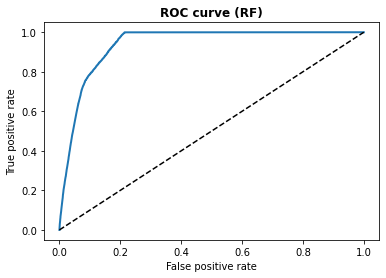

In [14]:
################################################
### random forest with no over/undersampling ###
################################################


# fit the model 

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train,Y_train)

prob_preds_rf = rf.predict_proba(X_val)[:,1]
Y_pred_rf = rf.predict(X_val)


# ROC curve

fpr_rf, tpr_rf, thresholds_rf = m.roc_curve(Y_val, prob_preds_rf)
roc_plot(fpr=fpr_rf,tpr=tpr_rf,model_name='RF')

rf_acc = m.accuracy_score(Y_val, Y_pred_rf)
rf_recall = m.recall_score(Y_val, Y_pred_rf)
rf_prec = m.precision_score(Y_val, Y_pred_rf)
rf_f1 = m.f1_score(Y_val, Y_pred_rf)
rf_fbeta = m.fbeta_score(Y_val, Y_pred_rf, beta)
rf_roc = m.roc_auc_score(Y_val, prob_preds_rf)

rf_stats = [rf_acc, rf_recall, rf_prec, rf_f1, rf_fbeta, rf_roc]

# diagnostic

print('\033[1m''Random Forest classification metrics with no resampling''\033[0m')
print('\033[1m''___________________________________________________________________________________________''\033[0m')
print('Random forest classification accuracy of: ', rf_acc)
print('Random forest classification recall of: ', rf_recall)
print('Random forest classification precision of: ', rf_prec)
print('Random forest classification F1 of: ', rf_f1)
print(f'Random forest classification (hard preds) F-beta ({beta}) of: ', rf_fbeta)

print('-----------------------------------------------------------')
print('')
print("ROC AUC score = ", rf_roc)

Random Forest classification metrics with resampling
___________________________________________________________________________________________
Random forest classification accuracy of:  0.8963095238095238
Random forest classification recall of:  0.7605157131345689
Random forest classification precision of:  0.5578673602080624
Random forest classification F1 of:  0.6436170212765957
Random forest classification F-beta (2) of:  0.7090056792571892
-----------------------------------------------------------

ROC AUC score =  0.9384385951973339


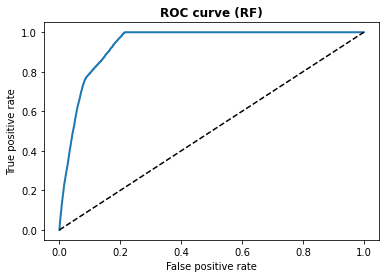

In [15]:
#############################################
### random forest with over/undersampling ###
#############################################


# fit the model 

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train_res,Y_train_res)

prob_preds_rf = rf.predict_proba(X_val)[:,1]
Y_pred_rf = rf.predict(X_val)


# ROC curve

fpr_rf, tpr_rf, thresholds_rf = m.roc_curve(Y_val, prob_preds_rf)
roc_plot(fpr=fpr_rf,tpr=tpr_rf,model_name='RF')

rf_acc_res = m.accuracy_score(Y_val, Y_pred_rf)
rf_recall_res = m.recall_score(Y_val, Y_pred_rf)
rf_prec_res = m.precision_score(Y_val, Y_pred_rf)
rf_f1_res = m.f1_score(Y_val, Y_pred_rf)
rf_fbeta_res = m.fbeta_score(Y_val, Y_pred_rf,beta)
rf_roc_res = m.roc_auc_score(Y_val, prob_preds_rf)

rf_stats_res = [rf_acc_res, rf_recall_res, rf_prec_res, rf_f1_res, rf_fbeta_res, rf_roc_res]


# diagnostic

print('\033[1m''Random Forest classification metrics with resampling''\033[0m')
print('\033[1m''___________________________________________________________________________________________''\033[0m')
print('Random forest classification accuracy of: ', rf_acc_res)
print('Random forest classification recall of: ', rf_recall_res)
print('Random forest classification precision of: ', rf_prec_res)
print('Random forest classification F1 of: ', rf_f1_res)
print(f'Random forest classification F-beta ({beta}) of: ', rf_fbeta_res)


print('-----------------------------------------------------------')
print('')
print("ROC AUC score = ", rf_roc_res)

In [30]:
stats_dict = {'KNN':knn_stats_res,
    'Logistic Regression':lr_stats_res,
    'Random Forest':rf_stats_res}

stats_df = pd.DataFrame(stats_dict).T.reset_index()
stats_df.columns = ['model','accuracy','recall','precision','f1','f-beta','roc']

stats_df[['model','recall','precision','f1','f-beta','roc']]
stats_df

,model,accuracy,recall,precision,f1,f-beta,roc
0,KNN,0.877460,0.812893,0.501441,0.620266,0.723071,0.880015
1,Logistic Regression,0.870456,0.032393,0.276860,0.058000,0.039341,0.577027
2,Random Forest,0.896310,0.760516,0.557867,0.643617,0.709006,0.938439


In [23]:
# test preds for 

Y_test_pred_knn = knn.predict(X_test)
Y_test_prob_pred_knn = knn.predict_proba(X_test)[:,1]

Y_test_pred_lr = lr.predict(X_test)
Y_test_prob_pred_lr = lr.predict_proba(X_test)[:,1]

Y_test_pred_rf = rf.predict(X_test)
Y_test_prob_pred_rf = rf.predict_proba(X_test)[:,1]


Text(457.44000000000005, 0.5, 'Actual')

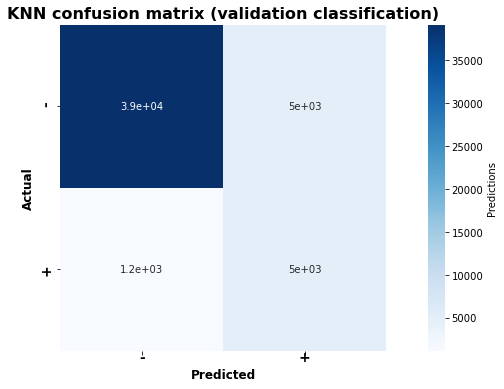

In [18]:
# confusion matrix for KNN, validation set

knn_confusion_val = m.confusion_matrix(Y_val,Y_pred_knn)

fig, ax = plt.subplots(figsize=(15,6))
ax=sns.heatmap(knn_confusion_val,
               ax = ax, 
               square=True, 
               cmap='Blues', 
               annot=True, 
               cbar_kws={'label':'Predictions'})

ax.set_title('KNN confusion matrix (validation classification)', fontweight='bold', fontsize=16)

# configure the x and y ticks

plt.xticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14, va='center')
plt.xlabel('Predicted',loc='center',fontweight='bold', fontsize=12)

plt.yticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14)
plt.ylabel('Actual', loc='center',fontweight='bold', fontsize=12)

Text(457.44000000000005, 0.5, 'Actual')

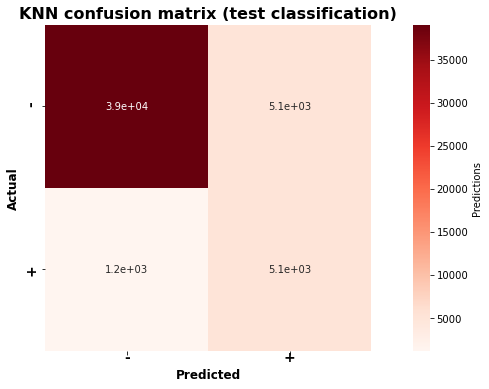

In [19]:
# confusion matrix for KNN, test set

knn_confusion_test = m.confusion_matrix(Y_test,Y_test_pred_knn)

fig, ax = plt.subplots(figsize=(15,6))
ax=sns.heatmap(knn_confusion_test,
               ax = ax, 
               square=True, 
               cmap='Reds', 
               annot=True, 
               cbar_kws={'label':'Predictions'})

ax.set_title('KNN confusion matrix (test classification)', fontweight='bold', fontsize=16)

# configure the x and y ticks

plt.xticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14, va='center')
plt.xlabel('Predicted',loc='center',fontweight='bold', fontsize=12)

plt.yticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14)
plt.ylabel('Actual', loc='center',fontweight='bold', fontsize=12)

Text(457.44000000000005, 0.5, 'Actual')

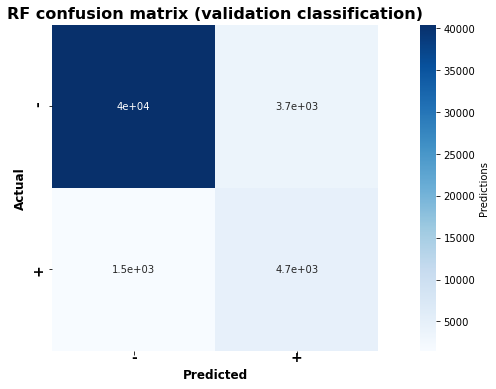

In [20]:
# confusion matrix for RF, validation set

rf_confusion_val = m.confusion_matrix(Y_val,Y_pred_rf)

fig, ax = plt.subplots(figsize=(15,6))
ax=sns.heatmap(rf_confusion_val,
               ax = ax, 
               square=True, 
               cmap='Blues', 
               annot=True, 
               cbar_kws={'label':'Predictions'})

ax.set_title('RF confusion matrix (validation classification)', fontweight='bold', fontsize=16)

# configure the x and y ticks

plt.xticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14, va='center')
plt.xlabel('Predicted',loc='center',fontweight='bold', fontsize=12)

plt.yticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14)
plt.ylabel('Actual', loc='center',fontweight='bold', fontsize=12)

Text(457.44000000000005, 0.5, 'Actual')

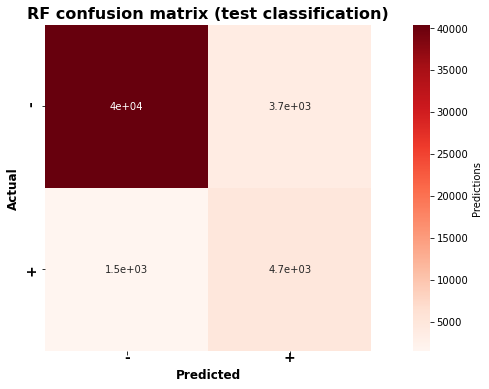

In [21]:
# confusion matrix for RF, test set

rf_confusion_test = m.confusion_matrix(Y_test,Y_test_pred_rf)

fig, ax = plt.subplots(figsize=(15,6))
ax=sns.heatmap(rf_confusion_test,
               ax = ax, 
               square=True, 
               cmap='Reds', 
               annot=True, 
               cbar_kws={'label':'Predictions'})

ax.set_title('RF confusion matrix (test classification)', fontweight='bold', fontsize=16)

# configure the x and y ticks

plt.xticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14, va='center')
plt.xlabel('Predicted',loc='center',fontweight='bold', fontsize=12)

plt.yticks(np.arange(2)+.5,['-','+'],fontweight='bold', fontsize=14)
plt.ylabel('Actual', loc='center',fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'ROC curve (validation)')

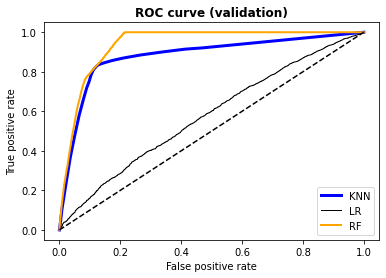

In [28]:
# KNN vs LR vs RF ROC_AUC

fpr_knn, tpr_knn, thresholds_knn = m.roc_curve(Y_val, prob_preds_knn)
fpr_lr, tpr_lr, thresholds_lr = m.roc_curve(Y_val, prob_preds_lr)
fpr_rf, tpr_rf, thresholds_rf = m.roc_curve(Y_val, prob_preds_rf)


plt.plot(fpr_knn, tpr_knn,lw=3, c='blue')
plt.plot(fpr_lr, tpr_lr,lw=1, c='black')
plt.plot(fpr_rf, tpr_rf,lw=2, c='orange')
plt.plot([0,1],[0,1], c='black', ls='--')


plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['KNN','LR','RF'])
plt.title('ROC curve (validation)',fontweight='bold')

Text(0.5, 1.0, 'Random Forest ROC curve (test)')

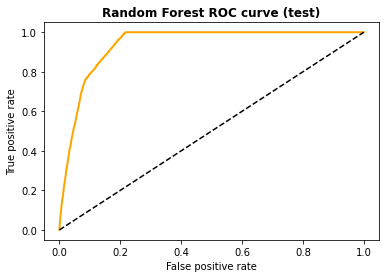

In [32]:
# RF ROC_AUC

fpr_rf, tpr_rf, thresholds_rf = m.roc_curve(Y_test, Y_test_prob_pred_rf)


plt.plot(fpr_rf, tpr_rf,lw=2, c='orange')
plt.plot([0,1],[0,1], c='black', ls='--')


plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve (test)',fontweight='bold')

In [35]:
print('\033[1m''RF results on test''\033[0m')
print('\033[1m''-----------------------------------------------''\033[0m')
print('Accuracy: ',m.accuracy_score(Y_test, Y_test_pred_rf))
print('Recall: ',m.recall_score(Y_test, Y_test_pred_rf))
print('Precision: ',m.precision_score(Y_test, Y_test_pred_rf))
print('F1: ',m.f1_score(Y_test, Y_test_pred_rf))
print('F-beta: ',m.fbeta_score(Y_test, Y_test_pred_rf,beta))
print('ROC: ',m.roc_auc_score(Y_test, Y_test_prob_pred_rf))

RF results on test
-----------------------------------------------
Accuracy:  0.8956150793650793
Recall:  0.7580361426515273
Precision:  0.558435438265787
F1:  0.6431042670103793
F-beta:  0.7074626865671643
ROC:  0.9378033040255929


Text(0.5, 1.0, 'RF feature importance')

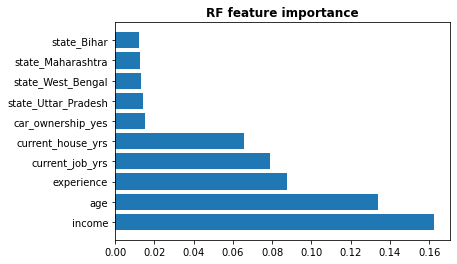

In [61]:
# top features of RF model


imp_feats_df = pd.DataFrame(list(zip(X_train.columns,rf.feature_importances_)))
imp_feats_df.columns = ['feature','importance']

top_feats = imp_feats_df.sort_values('importance',ascending=False).head(10)

plt.barh(y=top_feats.feature, width=top_feats.importance)
plt.title('RF feature importance',fontweight='bold')